<a href="https://colab.research.google.com/github/halenurk/UofTeco1400project/blob/main/Smooth_Durable_Adjustment_Problem_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==== 0. Imports and basic settings ====

import numpy as np
from math import erf, sqrt  # <-- add this

# For reproducibility (if you later simulate)
rng = np.random.default_rng(seed=123)


In [2]:
# ==== 1. Calibration parameters (annual frequency, smoother version) ====

# Preferences
beta   = 0.96     # discount factor
gamma  = 2.0      # CRRA for nondurables
xi     = 2.0      # CRRA for durables
theta  = 0.35     # weight on durable services

# Markets & technology
r      = 0.03     # real interest rate (slightly lower, less push to accumulate)
deltaK = 0.15     # depreciation of durables (slower than before)
pD     = 1.0      # price of durables (normalized)
a_min  = 0.0      # borrowing limit (no unsecured borrowing)

# Adjustment cost parameter (capital-scaled quadratic)
phi    = 6.0      # stronger convex friction to highlight durable stickiness

# Income process: log y_t = rho_y * log y_{t-1} + sigma_y * eps_t
rho_y   = 0.95    # persistence of income (unchanged)
sigma_y = 0.10    # smaller innovation std dev for log income (smoother)

# Normalization: mean income around 1
y_bar = 1.0


In [3]:
# ==== 2. Utility and helper functions ====

BIG_NEG = -1e12  # penalty for infeasible choices

def u_c(c, gamma):
    """CRRA utility from nondurable consumption."""
    if gamma == 1.0:
        return np.log(c)
    else:
        return (c**(1.0 - gamma)) / (1.0 - gamma)

def u_k(k, xi):
    """CRRA utility from durable services."""
    if xi == 1.0:
        return np.log(k)
    else:
        return (k**(1.0 - xi)) / (1.0 - xi)

def utility(c, k):
    """
    Period utility: u(c, k_t) = u_c(c) + theta * u_k(k).
    We assume durable services come from current stock k_t.
    """
    # impose non-negativity; small epsilon to avoid log(0)
    if c <= 0.0 or k <= 0.0:
        return BIG_NEG
    return u_c(c, gamma) + theta * u_k(k, xi)


In [7]:
# ==== 3. Income process: Tauchen discretization ====

def tauchen(N, rho, sigma, m=3.0):
    """
    Tauchen (1986) discretization of AR(1):
        z' = rho * z + sigma * eps, eps ~ N(0,1)
    Returns: z_grid (N,), P (N x N)
    """

    # stationary std dev of z
    sigma_z = sigma / np.sqrt(1.0 - rho**2)
    z_max   = m * sigma_z
    z_min   = -z_max
    z_grid  = np.linspace(z_min, z_max, N)
    step    = (z_max - z_min) / (N - 1)

    P = np.zeros((N, N))

    # standard normal CDF using erf
    def Phi(x):
        return 0.5 * (1.0 + erf(x / sqrt(2.0)))

    for i in range(N):
        for j in range(N):
            if j == 0:
                z_low  = -np.inf
                z_high = (z_grid[0] + z_grid[1]) / 2.0
            elif j == N - 1:
                z_low  = (z_grid[N-2] + z_grid[N-1]) / 2.0
                z_high = np.inf
            else:
                z_low  = (z_grid[j-1] + z_grid[j]) / 2.0
                z_high = (z_grid[j] + z_grid[j+1]) / 2.0

            mean = rho * z_grid[i]

            # probability that z' lies in [z_low, z_high]
            # z' ~ N(mean, sigma^2)
            P[i, j] = Phi((z_high - mean) / sigma) - Phi((z_low - mean) / sigma)

    return z_grid, P

# Number of income states
Ny = 9  # you can increase later (e.g., 7 or 9)

z_grid, P_y = tauchen(Ny, rho_y, sigma_y, m=2.0)
y_grid = y_bar * np.exp(z_grid)  # income in levels


In [4]:
# ==== 4. Grids for assets and durables ====

Na = 60          # number of asset grid points (start modest)
Nk = 25          # number of durable grid points

a_max = 15.0     # max assets (in units of income)
k_max = 4.0      # max durable stock

a_grid = np.linspace(a_min, a_max, Na)
# avoid exactly zero for k to prevent utility issues; start at small epsilon
k_grid = np.linspace(0.05, k_max, Nk)


In [5]:
# ==== 5. Precompute consumption for all (a, k, a', k') ====

# We'll build arrays:
# c_all[ia, ik, ja, jk, iy] = current-period consumption
# BUT to save memory we can drop iy from c (income is just y_grid[iy])
# and apply income later. So we precompute net resources ignoring income.

# "Cash-on-hand before y_t" for each (ia)
R = (1.0 + r) * a_grid  # shape (Na,)

# For given (k, k'), investment and adjustment cost:
# i = k' - (1 - deltaK) * k
# Phi = 0.5 * phi * ( (k'/k - 1)^2 * k )

# We'll store investment rate and cost as 2D arrays over (ik, jk)
k_mat    = k_grid.reshape(Nk, 1)           # (Nk, 1)
k_prime  = k_grid.reshape(1, Nk)           # (1, Nk)
i_mat    = k_prime - (1.0 - deltaK) * k_mat
# avoid division by zero: k_grid starts at 0.05 so we're safe
inv_rate = i_mat / k_mat                  # (Nk, Nk)
Phi_mat  = 0.5 * phi * (inv_rate - deltaK)**2 * k_mat  # (Nk, Nk)

# We'll compute c for each income state on the fly:
# c(ia, ik, ja, jk, iy) = R[ia] + y_grid[iy] - a_grid[ja] - pD * i_mat[ik,jk] - Phi_mat[ik,jk]
# and enforce c > 0 by masking in the Bellman step.


In [8]:
# ==== 6. Initialization of value and policy arrays ====

# Value function V[a, k, y]
V = np.zeros((Na, Nk, Ny))

# Policy indices (store indices of optimal next-period a' and k')
pol_a_idx = np.zeros((Na, Nk, Ny), dtype=int)
pol_k_idx = np.zeros((Na, Nk, Ny), dtype=int)

# Convergence settings
max_iter = 500
tol      = 1e-5


In [8]:
# ==== 7. Value function iteration ====

for it in range(max_iter):
    V_new = np.empty_like(V)

    # Loop over income states
    for iy in range(Ny):
        y = y_grid[iy]

        # Precompute expected continuation value for choosing (a', k') given current iy:
        # EV_next[ja, jk] = sum_{iy'} P_y[iy, iy'] * V[ja, jk, iy']
        EV_next = np.tensordot(V[:, :, :], P_y[iy, :], axes=(2, 0))  # shape (Na, Nk)

        # Loop over current (a, k)
        for ia in range(Na):
            R_ia = R[ia] + y  # cash-on-hand including income

            for ik in range(Nk):
                k_now = k_grid[ik]

                best_val = BIG_NEG
                best_ja  = 0
                best_jk  = 0

                # Loop over possible (a', k') choices
                for ja in range(Na):
                    a_next = a_grid[ja]
                    if a_next < a_min:
                        continue

                    # Vectorize over all k' at once to speed up inner loop:
                    # c_jk = R_ia - a_next - pD * i(ik,jk) - Phi(ik,jk)
                    # where i(ik,jk) and Phi(ik,jk) are from precomputed matrices
                    c_vec = (
                        R_ia
                        - a_next
                        - pD * i_mat[ik, :]    # dimension (Nk,)
                        - Phi_mat[ik, :]       # dimension (Nk,)
                    )

                    # Feasibility mask: c > 0 and k' > 0 automatically (k_grid > 0)
                    feasible = c_vec > 1e-12
                    if not np.any(feasible):
                        continue

                    # Compute utility only for feasible k'
                    u_vec = np.full(Nk, BIG_NEG)
                    # durable services from current k_now (not k')
                    u_vec[feasible] = np.array(
                        [utility(c_vec[jk], k_now) for jk in np.where(feasible)[0]]
                    )

                    # Total value for each feasible k': u + beta * EV_next[ja, jk]
                    v_vec = u_vec + beta * EV_next[ja, :]

                    # Find best k' for this a'
                    jk_best_local = int(np.argmax(v_vec))
                    v_best_local  = v_vec[jk_best_local]

                    # Update global best (over a' and k')
                    if v_best_local > best_val:
                        best_val = v_best_local
                        best_ja  = ja
                        best_jk  = jk_best_local

                # Store best value and policies for (ia, ik, iy)
                V_new[ia, ik, iy]   = best_val
                pol_a_idx[ia, ik, iy] = best_ja
                pol_k_idx[ia, ik, iy] = best_jk

    # Check convergence
    diff = np.max(np.abs(V_new - V))
    print(f"Iter {it+1}: sup-norm diff = {diff:.3e}")
    V = V_new

    if diff < tol:
        print("Value function converged.")
        break
else:
    print("WARNING: VFI did not converge within max_iter.")


KeyboardInterrupt: 

In [9]:
import os

# Define filenames for caching
v_filename = "value_function.npy"
policy_a_filename = "policy_a.npy"
policy_k_filename = "policy_k.npy"

# Toggle this to force re-running even if files exist
FORCE_RERUN = False


    # ==== Save Results ====
print("Saving results to disk...")
np.save(v_filename, V)
np.save(policy_a_filename, pol_a_idx)
np.save(policy_k_filename, pol_k_idx)
print("Saved.")

Saving results to disk...
Saved.


In [10]:
# ==== 8. Policy functions in levels ====

pol_a = a_grid[pol_a_idx]  # shape (Na, Nk, Ny)
pol_k = k_grid[pol_k_idx]  # shape (Na, Nk, Ny)

# For completeness, you can also recover implied consumption policy:
# c(a,k,y) = (1+r)*a + y - a' - pD * i - Phi
pol_c = np.empty_like(pol_a)

for iy in range(Ny):
    y = y_grid[iy]
    for ia in range(Na):
        R_ia = (1.0 + r) * a_grid[ia] + y
        for ik in range(Nk):
            k_now   = k_grid[ik]
            a_next  = pol_a[ia, ik, iy]
            k_next  = pol_k[ia, ik, iy]
            # investment and cost
            i_now   = k_next - (1.0 - deltaK) * k_now
            inv_rate = i_now / k_now
            Phi_now = 0.5 * phi * (inv_rate - deltaK)**2 * k_now

            pol_c[ia, ik, iy] = R_ia - a_next - pD * i_now - Phi_now


In [11]:
# ==== 9. Single-household simulation with one income shock ====

T_sim = 120

a_path = np.zeros(T_sim)
k_path = np.zeros(T_sim)
y_path = np.zeros(T_sim)
c_path = np.zeros(T_sim)
i_path = np.zeros(T_sim)

ia_path = np.zeros(T_sim, dtype=int)
ik_path = np.zeros(T_sim, dtype=int)
iy_path = np.zeros(T_sim, dtype=int)

# Start in middle income state
iy_mid = Ny // 2

ia_path[0] = 0
ik_path[0] = Nk // 2
iy_path[0] = iy_mid

a_path[0] = a_grid[ia_path[0]]
k_path[0] = k_grid[ik_path[0]]
y_path[0] = y_grid[iy_mid]

shock_date = 40           # when we hit a higher income state
iy_high    = iy_mid + 2   # two steps up on the income grid (check Ny>=iy_mid+3)

for t in range(T_sim - 1):
    ia = ia_path[t]
    ik = ik_path[t]
    iy = iy_path[t]

    a_t = a_grid[ia]
    k_t = k_grid[ik]
    y_t = y_grid[iy]

    # Policies
    ia_next = pol_a_idx[ia, ik, iy]
    ik_next = pol_k_idx[ia, ik, iy]

    a_next = a_grid[ia_next]
    k_next = k_grid[ik_next]

    # Income path: stay at mid, except jump up permanently at shock_date
    if t < shock_date:
        iy_next = iy_mid
    else:
        iy_next = iy_high
    y_next = y_grid[iy_next]

    # Current c and i
    i_t = k_next - (1.0 - deltaK) * k_t
    inv_rate = i_t / k_t
    Phi_t = 0.5 * phi * (inv_rate - deltaK)**2 * k_t

    R_t = (1.0 + r) * a_t + y_t
    c_t = R_t - a_next - pD * i_t - Phi_t

    i_path[t] = i_t
    c_path[t] = c_t

    a_path[t+1]  = a_next
    k_path[t+1]  = k_next
    y_path[t+1]  = y_next
    ia_path[t+1] = ia_next
    ik_path[t+1] = ik_next
    iy_path[t+1] = iy_next


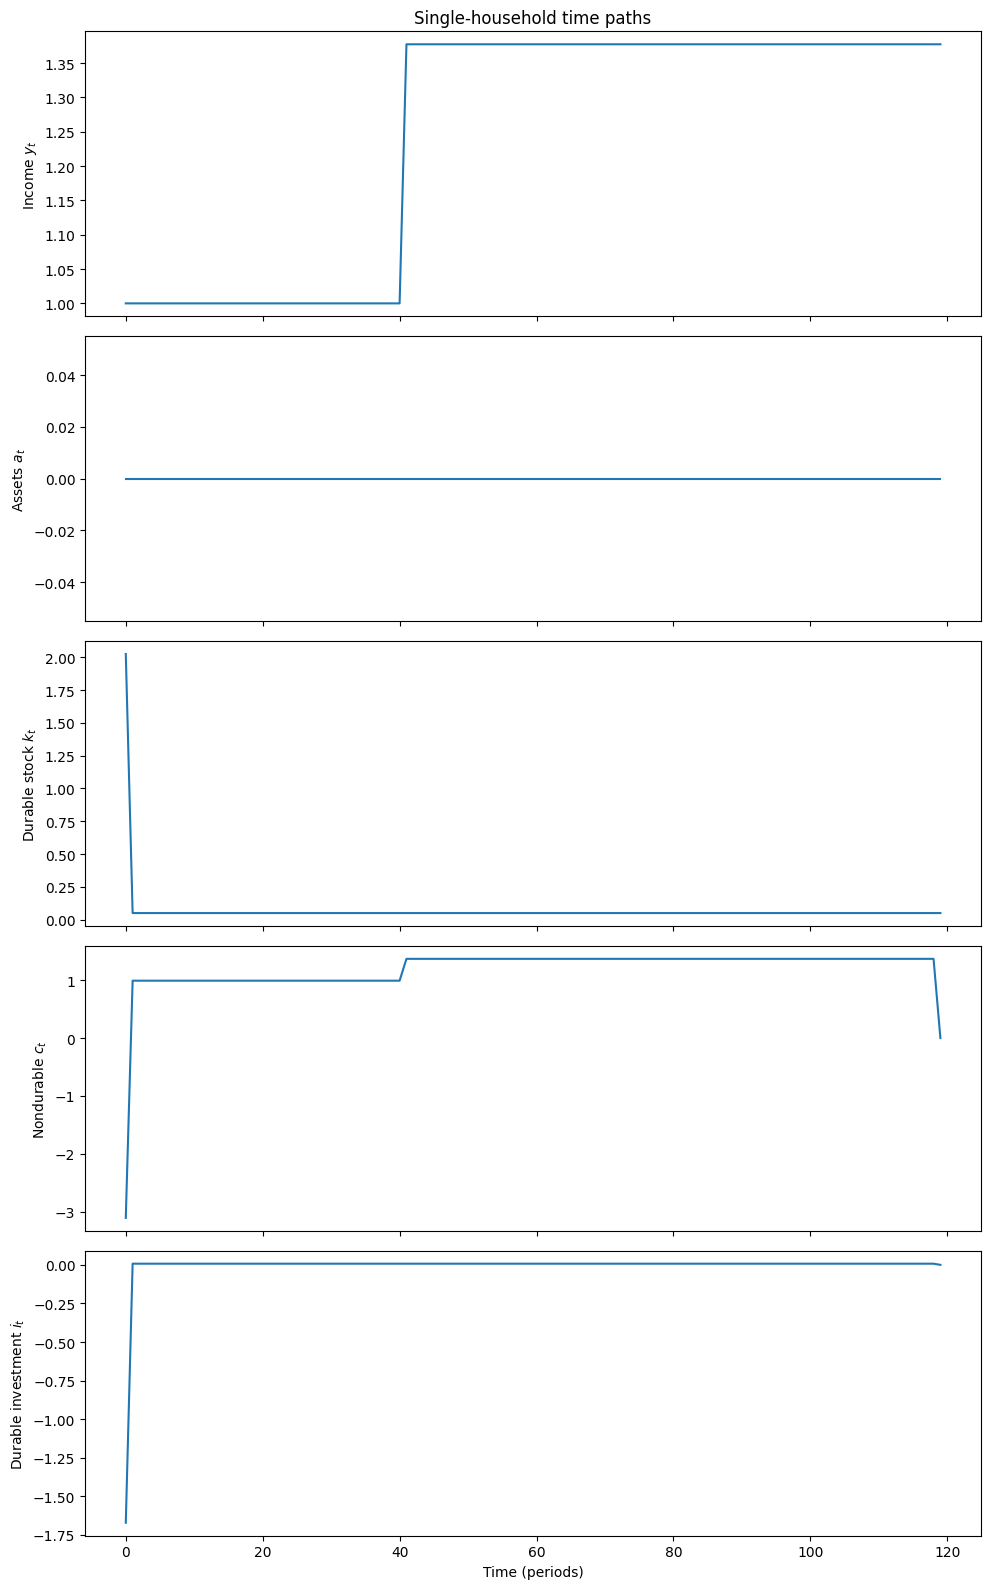

In [12]:
# ==== 10. Plot time paths for key variables ====
import matplotlib.pyplot as plt

T_plot = T_sim  # or use a subset like 100

t_grid = np.arange(T_plot)

fig, axes = plt.subplots(5, 1, figsize=(10, 16), sharex=True)

# 1) Income
axes[0].plot(t_grid, y_path[:T_plot])
axes[0].set_ylabel("Income $y_t$")
axes[0].set_title("Single-household time paths")

# 2) Assets
axes[1].plot(t_grid, a_path[:T_plot])
axes[1].set_ylabel("Assets $a_t$")

# 3) Durable stock
axes[2].plot(t_grid, k_path[:T_plot])
axes[2].set_ylabel("Durable stock $k_t$")

# 4) Nondurable consumption
axes[3].plot(t_grid, c_path[:T_plot])
axes[3].set_ylabel("Nondurable $c_t$")

# 5) Durable investment
axes[4].plot(t_grid, i_path[:T_plot])
axes[4].set_ylabel("Durable investment $i_t$")
axes[4].set_xlabel("Time (periods)")

plt.tight_layout()
plt.show()


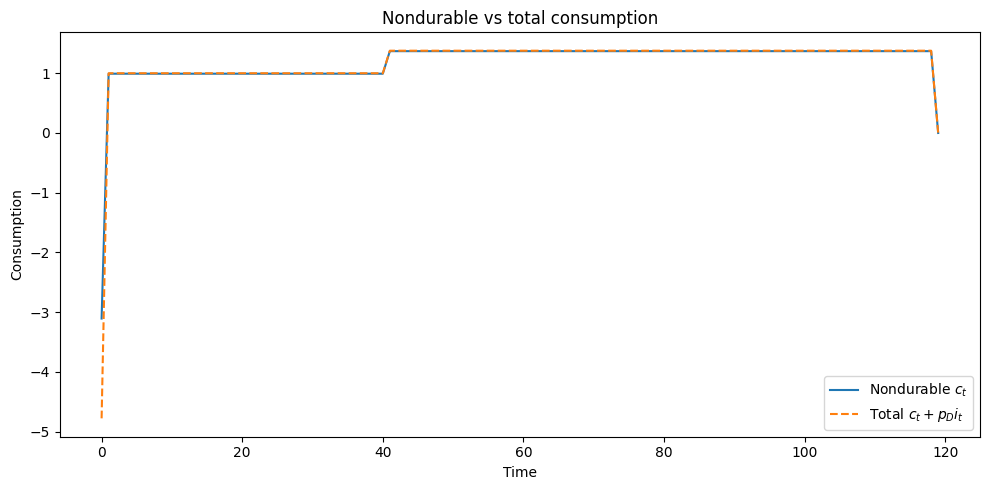

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

total_cons_path = c_path + pD * i_path

ax.plot(t_grid, c_path[:T_plot], label="Nondurable $c_t$")
ax.plot(t_grid, total_cons_path[:T_plot], label="Total $c_t + p_D i_t$", linestyle="--")

ax.set_xlabel("Time")
ax.set_ylabel("Consumption")
ax.set_title("Nondurable vs total consumption")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Policy function plots: durable investment

In [ ]:
# ==== A1. Durable investment policy i(a,k | y) ====

import matplotlib.pyplot as plt
import numpy as np

# Choose an income state: middle and high for comparison
iy_mid  = Ny // 2
iy_high = min(Ny - 1, iy_mid + 2)  # make sure we stay in range

def compute_investment_policy(iy_idx):
    """
    Returns a matrix invest[ia, ik] with durable investment i_t
    as a function of (a_t, k_t) at income state y_grid[iy_idx].
    """
    invest = np.zeros((Na, Nk))
    for ia in range(Na):
        for ik in range(Nk):
            k_now = k_grid[ik]
            jk    = pol_k_idx[ia, ik, iy_idx]
            k_next = k_grid[jk]
            i_now  = k_next - (1.0 - deltaK) * k_now
            invest[ia, ik] = i_now
    return invest

inv_mid  = compute_investment_policy(iy_mid)
inv_high = compute_investment_policy(iy_high)


In [ ]:
# ==== A2. Plot durable investment heatmaps ====

def plot_investment_heatmap(inv_mat, iy_idx, title_suffix=""):
    fig, ax = plt.subplots(figsize=(8, 5))

    # imshow expects [row, col] ~ [y, x]; we want x=a, y=k so transpose
    im = ax.imshow(
        inv_mat.T,
        origin="lower",
        extent=(a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]),
        aspect="auto"
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Durable investment $i_t$")

    ax.set_xlabel("Assets $a_t$")
    ax.set_ylabel("Durable stock $k_t$")
    ax.set_title(f"Durable investment policy, y = {y_grid[iy_idx]:.2f} {title_suffix}")

    plt.tight_layout()
    plt.show()

plot_investment_heatmap(inv_mid,  iy_mid,  "(middle income)")
plot_investment_heatmap(inv_high, iy_high, "(high income)")


In [ ]:
# Deterministic impulse responses

In [ ]:
# ==== B1. Deterministic impulse-response simulator ====

def simulate_impulse(ia0, ik0, iy_before, iy_after, T=80, shock_date=20):
    """
    Deterministic path:
    - Income y = y_before up to t < shock_date
    - Income y = y_after from t >= shock_date
    Returns dict with paths for a, k, y, c, i.
    """
    a_path = np.zeros(T)
    k_path = np.zeros(T)
    y_path = np.zeros(T)
    c_path = np.zeros(T)
    i_path = np.zeros(T)

    ia_path = np.zeros(T, dtype=int)
    ik_path = np.zeros(T, dtype=int)
    iy_path = np.zeros(T, dtype=int)

    ia_path[0] = ia0
    ik_path[0] = ik0
    iy_path[0] = iy_before

    a_path[0] = a_grid[ia0]
    k_path[0] = k_grid[ik0]
    y_path[0] = y_grid[iy_before]

    for t in range(T - 1):
        ia = ia_path[t]
        ik = ik_path[t]
        iy = iy_path[t]

        a_t = a_grid[ia]
        k_t = k_grid[ik]
        y_t = y_grid[iy]

        # Policy indices
        ia_next = pol_a_idx[ia, ik, iy]
        ik_next = pol_k_idx[ia, ik, iy]

        a_next = a_grid[ia_next]
        k_next = k_grid[ik_next]

        # Income regime
        iy_next = iy_before if t+1 < shock_date else iy_after
        y_next  = y_grid[iy_next]

        # Current i_t and c_t
        i_t = k_next - (1.0 - deltaK) * k_t
        inv_rate = i_t / k_t
        Phi_t    = 0.5 * phi * (inv_rate - deltaK)**2 * k_t

        R_t = (1.0 + r) * a_t + y_t
        c_t = R_t - a_next - pD * i_t - Phi_t

        i_path[t] = i_t
        c_path[t] = c_t

        a_path[t+1]  = a_next
        k_path[t+1]  = k_next
        y_path[t+1]  = y_next
        ia_path[t+1] = ia_next
        ik_path[t+1] = ik_next
        iy_path[t+1] = iy_next

    # compute final-period c and i as well (optional)
    t = T - 1
    ia = ia_path[t]
    ik = ik_path[t]
    iy = iy_path[t]

    a_t = a_grid[ia]
    k_t = k_grid[ik]
    y_t = y_grid[iy]

    ia_next = pol_a_idx[ia, ik, iy]
    ik_next = pol_k_idx[ia, ik, iy]
    a_next  = a_grid[ia_next]
    k_next  = k_grid[ik_next]

    i_t = k_next - (1.0 - deltaK) * k_t
    inv_rate = i_t / k_t
    Phi_t    = 0.5 * phi * (inv_rate - deltaK)**2 * k_t
    R_t      = (1.0 + r) * a_t + y_t
    c_t      = R_t - a_next - pD * i_t - Phi_t

    i_path[t] = i_t
    c_path[t] = c_t

    return {
        "a": a_path,
        "k": k_path,
        "y": y_path,
        "c": c_path,
        "i": i_path,
    }


In [ ]:
# ==== B2. Run impulse + plot for low vs high initial wealth ====

T_IR      = 80
shock_t   = 20
iy_before = iy_mid
iy_after  = iy_high

# Low-wealth initial state
ia_low = 1              # near borrowing constraint
ik0    = Nk // 2        # mid durable stock

# High-wealth initial state
ia_high = Na // 2       # richer

res_low  = simulate_impulse(ia_low,  ik0, iy_before, iy_after, T=T_IR, shock_date=shock_t)
res_high = simulate_impulse(ia_high, ik0, iy_before, iy_after, T=T_IR, shock_date=shock_t)

t_grid = np.arange(T_IR)

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Income (same for both)
axes[0].plot(t_grid, res_low["y"],  label="Income")
axes[0].axvline(shock_t, linestyle="--")
axes[0].set_ylabel("$y_t$")
axes[0].set_title("Impulse response to permanent income increase")

# Durables
axes[1].plot(t_grid, res_low["k"],  label="low wealth")
axes[1].plot(t_grid, res_high["k"], label="high wealth", linestyle="--")
axes[1].set_ylabel("Durable stock $k_t$")
axes[1].legend()

# Nondurable consumption
axes[2].plot(t_grid, res_low["c"],  label="low wealth")
axes[2].plot(t_grid, res_high["c"], label="high wealth", linestyle="--")
axes[2].set_ylabel("Nondurable $c_t$")
axes[2].set_xlabel("Time")

plt.tight_layout()
plt.show()


In [ ]:
# Cross-section simulation (for quantile regressions later)

In [ ]:
# ==== C1. Cross-sectional simulation ====

import pandas as pd

def simulate_cross_section(N_agents=5000, T_total=400, burn_in=300):
    """
    Simulate many households with stochastic income and return
    a DataFrame for one post-burn-in period (cross-section).
    """
    assert burn_in < T_total

    # indices
    ia = np.zeros(N_agents, dtype=int)
    ik = np.zeros(N_agents, dtype=int)
    iy = np.full(N_agents, Ny // 2, dtype=int)  # start at middle income

    # levels
    a  = a_grid[ia]
    k  = k_grid[ik]
    y  = y_grid[iy]

    for t in range(T_total):
        # arrays to store flows this period (for final cross-section)
        if t == burn_in:
            c_t = np.zeros(N_agents)
            i_t = np.zeros(N_agents)

        # apply policies & income shocks
        for n in range(N_agents):
            ia_n = ia[n]
            ik_n = ik[n]
            iy_n = iy[n]

            a_n = a_grid[ia_n]
            k_n = k_grid[ik_n]
            y_n = y_grid[iy_n]

            # next-period indices via policies
            ia_next = pol_a_idx[ia_n, ik_n, iy_n]
            ik_next = pol_k_idx[ia_n, ik_n, iy_n]

            a_next = a_grid[ia_next]
            k_next = k_grid[ik_next]

            # draw next income state
            iy_next = rng.choice(Ny, p=P_y[iy_n, :])
            y_next  = y_grid[iy_next]

            # current flows
            i_now = k_next - (1.0 - deltaK) * k_n
            inv_rate = i_now / k_n
            Phi_now = 0.5 * phi * (inv_rate - deltaK)**2 * k_n
            R_now   = (1.0 + r) * a_n + y_n
            c_now   = R_now - a_next - pD * i_now - Phi_now

            if t == burn_in:
                c_t[n] = c_now
                i_t[n] = i_now

            # update states
            ia[n] = ia_next
            ik[n] = ik_next
            iy[n] = iy_next
            a[n]  = a_next
            k[n]  = k_next
            y[n]  = y_next

    # build cross-section DataFrame at time burn_in
    df = pd.DataFrame({
        "income": y,
        "assets": a,
        "durables": k,
        "c_nondur": c_t,
        "i_dur": i_t
    })
    df["c_total"] = df["c_nondur"] + pD * df["i_dur"]

    return df

df_cross = simulate_cross_section()
df_cross.head()


In [ ]:
# ==== C2. Example quantile regression on simulated data ====

import statsmodels.formula.api as smf

taus = [0.1, 0.5, 0.9]

for tau in taus:
    print(f"\nQuantile {tau:.1f}: nondurable consumption on income and assets")
    mod = smf.quantreg("c_nondur ~ income + assets", df_cross)
    res = mod.fit(q=tau)
    print(res.params)

for tau in taus:
    print(f"\nQuantile {tau:.1f}: total consumption on income and assets")
    mod = smf.quantreg("c_total ~ income + assets", df_cross)
    res = mod.fit(q=tau)
    print(res.params)


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
# Use a finer grid of quantiles for plotting smooth lines
taus = np.arange(0.05, 0.96, 0.05)

# Storage for results
results = []

print(f"Running Quantile Regressions for {len(taus)} quantiles...")

for tau in taus:
    # 1. Nondurable Consumption Regression
    mod_n = smf.quantreg("c_nondur ~ income + assets", df_cross)
    res_n = mod_n.fit(q=tau)

    # 2. Total Consumption Regression
    mod_t = smf.quantreg("c_total ~ income + assets", df_cross)
    res_t = mod_t.fit(q=tau)

    # Store Income Coeffs
    results.append({
        'Quantile': tau,
        'Variable': 'Income',
        'Coefficient': res_n.params['income'],
        'Type': 'Nondurable',
        'Lower': res_n.conf_int().loc['income', 0],
        'Upper': res_n.conf_int().loc['income', 1]
    })
    results.append({
        'Quantile': tau,
        'Variable': 'Income',
        'Coefficient': res_t.params['income'],
        'Type': 'Total',
        'Lower': res_t.conf_int().loc['income', 0],
        'Upper': res_t.conf_int().loc['income', 1]
    })

    # Store Asset Coeffs
    results.append({
        'Quantile': tau,
        'Variable': 'Assets',
        'Coefficient': res_n.params['assets'],
        'Type': 'Nondurable',
        'Lower': res_n.conf_int().loc['assets', 0],
        'Upper': res_n.conf_int().loc['assets', 1]
    })
    results.append({
        'Quantile': tau,
        'Variable': 'Assets',
        'Coefficient': res_t.params['assets'],
        'Type': 'Total',
        'Lower': res_t.conf_int().loc['assets', 0],
        'Upper': res_t.conf_int().loc['assets', 1]
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# --- Plotting ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Income Coefficients (MPC out of Income)
subset_inc = df_results[df_results['Variable'] == 'Income']
sns.lineplot(
    data=subset_inc, x='Quantile', y='Coefficient', hue='Type',
    style='Type', markers=True, dashes=False, linewidth=2.5, ax=axes[0]
)
axes[0].set_title('Responsiveness to INCOME', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Coefficient Estimate')
axes[0].set_xlabel('Quantile ($\\tau$)')
axes[0].legend(title='Consumption Type')

# Plot 2: Asset Coefficients (MPC out of Assets)
subset_ast = df_results[df_results['Variable'] == 'Assets']
sns.lineplot(
    data=subset_ast, x='Quantile', y='Coefficient', hue='Type',
    style='Type', markers=True, dashes=False, linewidth=2.5, ax=axes[1]
)
axes[1].set_title('Responsiveness to ASSETS', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Coefficient Estimate')
axes[1].set_xlabel('Quantile ($\\tau$)')
axes[1].legend(title='Consumption Type')

plt.suptitle('Structural Model: Quantile Regression Results', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [16]:
# ==== Heatmaps with and without frictions ====
# 1) Helper: solve the DP for a given adjustment cost parameter phi_val
#    (self-contained: recomputes i_mat and inv_rate internally)

def solve_model_for_phi(phi_val, max_iter=500, tol=1e-5, verbose=True):
    """
    Solve the durable consumption DP for a given adjustment cost parameter phi_val.
    Uses existing global grids (a_grid, k_grid, y_grid), and parameters (r, beta, pD, deltaK).
    Returns: V_loc, pol_a_idx_loc, pol_k_idx_loc.
    """

    # --- Local precomputation for this phi_val ---

    # Cash-on-hand before income for each asset level
    R_loc = (1.0 + r) * a_grid  # shape (Na,)

    # For given (k, k'): investment and adjustment cost
    k_mat_loc   = k_grid.reshape(Nk, 1)        # (Nk, 1)
    k_prime_loc = k_grid.reshape(1, Nk)        # (1, Nk)
    i_mat_loc   = k_prime_loc - (1.0 - deltaK) * k_mat_loc
    inv_rate_loc = i_mat_loc / k_mat_loc       # (Nk, Nk), since k_grid > 0

    # Adjustment cost matrix for this phi
    Phi_mat_use = 0.5 * phi_val * (inv_rate_loc - deltaK)**2 * k_mat_loc  # (Nk, Nk)

    # --- Initialize value and policy arrays ---

    V_loc = np.zeros((Na, Nk, Ny))
    pol_a_idx_loc = np.zeros((Na, Nk, Ny), dtype=int)
    pol_k_idx_loc = np.zeros((Na, Nk, Ny), dtype=int)

    # --- Value function iteration ---

    for it in range(max_iter):
        V_new = np.empty_like(V_loc)

        # Loop over current income states
        for iy in range(Ny):
            y = y_grid[iy]

            # Expected continuation value for each (a', k') given current iy:
            # EV_next[ja, jk] = sum_{iy'} P_y[iy, iy'] * V_loc[ja, jk, iy']
            EV_next = np.tensordot(V_loc, P_y[iy, :], axes=(2, 0))  # (Na, Nk)

            # Loop over current (a, k)
            for ia in range(Na):
                R_ia = R_loc[ia] + y  # cash-on-hand including income

                for ik in range(Nk):
                    k_now = k_grid[ik]

                    best_val = BIG_NEG
                    best_ja  = 0
                    best_jk  = 0

                    # Loop over next-period assets a'
                    for ja in range(Na):
                        a_next = a_grid[ja]

                        # Vectorized over all k' at once:
                        # c_jk = R_ia - a_next - pD * i_mat_loc[ik, jk] - Phi_mat_use[ik, jk]
                        c_vec = (
                            R_ia
                            - a_next
                            - pD * i_mat_loc[ik, :]
                            - Phi_mat_use[ik, :]
                        )

                        # Feasibility: c > 0
                        feasible = c_vec > 1e-12
                        if not np.any(feasible):
                            continue

                        # Utility for feasible k'
                        u_vec = np.full(Nk, BIG_NEG)
                        feas_idx = np.where(feasible)[0]
                        u_vec[feas_idx] = np.array(
                            [utility(c_vec[jk_idx], k_now) for jk_idx in feas_idx]
                        )

                        # Total value: u + beta * EV_next(a', k')
                        v_vec = u_vec + beta * EV_next[ja, :]

                        # Best k' at this a'
                        jk_best_local = int(np.argmax(v_vec))
                        v_best_local  = v_vec[jk_best_local]

                        # Update global best over (a', k')
                        if v_best_local > best_val:
                            best_val = v_best_local
                            best_ja  = ja
                            best_jk  = jk_best_local

                    # Store best value and policies for (ia, ik, iy)
                    V_new[ia, ik, iy]          = best_val
                    pol_a_idx_loc[ia, ik, iy]  = best_ja
                    pol_k_idx_loc[ia, ik, iy]  = best_jk

        # Convergence check
        diff = np.max(np.abs(V_new - V_loc))
        if verbose:
            print(f"[phi={phi_val:.3f}] iter {it+1}: sup diff = {diff:.3e}")

        V_loc = V_new

        if diff < tol:
            if verbose:
                print(f"[phi={phi_val:.3f}] Value function converged for phi={phi_val:.3f}.")
            break
    else:
        print(f"WARNING: VFI did not converge for phi={phi_val:.3f} (max_iter reached).")

    return V_loc, pol_a_idx_loc, pol_k_idx_loc


In [18]:
# 2) Solve the frictionless version (phi = 0)
phi_frictionless = 0.0
V_nofric, pol_a_idx_nofric, pol_k_idx_nofric = solve_model_for_phi(
    phi_val=phi_frictionless,
    max_iter=500,
    tol=1e-5,
    verbose=True,
)


[phi=0.000] iter 1: sup diff = 8.925e+00
[phi=0.000] iter 2: sup diff = 3.855e+00
[phi=0.000] iter 3: sup diff = 3.175e+00
[phi=0.000] iter 4: sup diff = 2.579e+00
[phi=0.000] iter 5: sup diff = 2.347e+00
[phi=0.000] iter 6: sup diff = 2.176e+00
[phi=0.000] iter 7: sup diff = 1.997e+00
[phi=0.000] iter 8: sup diff = 1.857e+00
[phi=0.000] iter 9: sup diff = 1.731e+00
[phi=0.000] iter 10: sup diff = 1.617e+00
[phi=0.000] iter 11: sup diff = 1.515e+00
[phi=0.000] iter 12: sup diff = 1.423e+00
[phi=0.000] iter 13: sup diff = 1.339e+00
[phi=0.000] iter 14: sup diff = 1.261e+00
[phi=0.000] iter 15: sup diff = 1.190e+00
[phi=0.000] iter 16: sup diff = 1.125e+00
[phi=0.000] iter 17: sup diff = 1.064e+00
[phi=0.000] iter 18: sup diff = 1.007e+00
[phi=0.000] iter 19: sup diff = 9.545e-01
[phi=0.000] iter 20: sup diff = 9.053e-01
[phi=0.000] iter 21: sup diff = 8.593e-01
[phi=0.000] iter 22: sup diff = 8.162e-01
[phi=0.000] iter 23: sup diff = 7.757e-01
[phi=0.000] iter 24: sup diff = 7.377e-01
[

In [19]:
# 3) Build investment-rate policies i_t/k_t on the (a, k, y) grid

def compute_inv_rate_policy(pol_k_idx_in):
    """
    Given policy indices for k' (shape (Na, Nk, Ny)),
    build the investment rate i_t/k_t on the same grid.
    """
    inv_rate_policy = np.empty((Na, Nk, Ny))

    for iy in range(Ny):
        for ia in range(Na):
            for ik in range(Nk):
                jk_next = pol_k_idx_in[ia, ik, iy]
                k_now   = k_grid[ik]
                k_next  = k_grid[jk_next]
                i_now   = k_next - (1.0 - deltaK) * k_now
                inv_rate_policy[ia, ik, iy] = i_now / k_now

    return inv_rate_policy

# Baseline (with frictions) uses existing pol_k_idx
inv_rate_fric   = compute_inv_rate_policy(pol_k_idx)

# Frictionless benchmark
inv_rate_nofric = compute_inv_rate_policy(pol_k_idx_nofric)


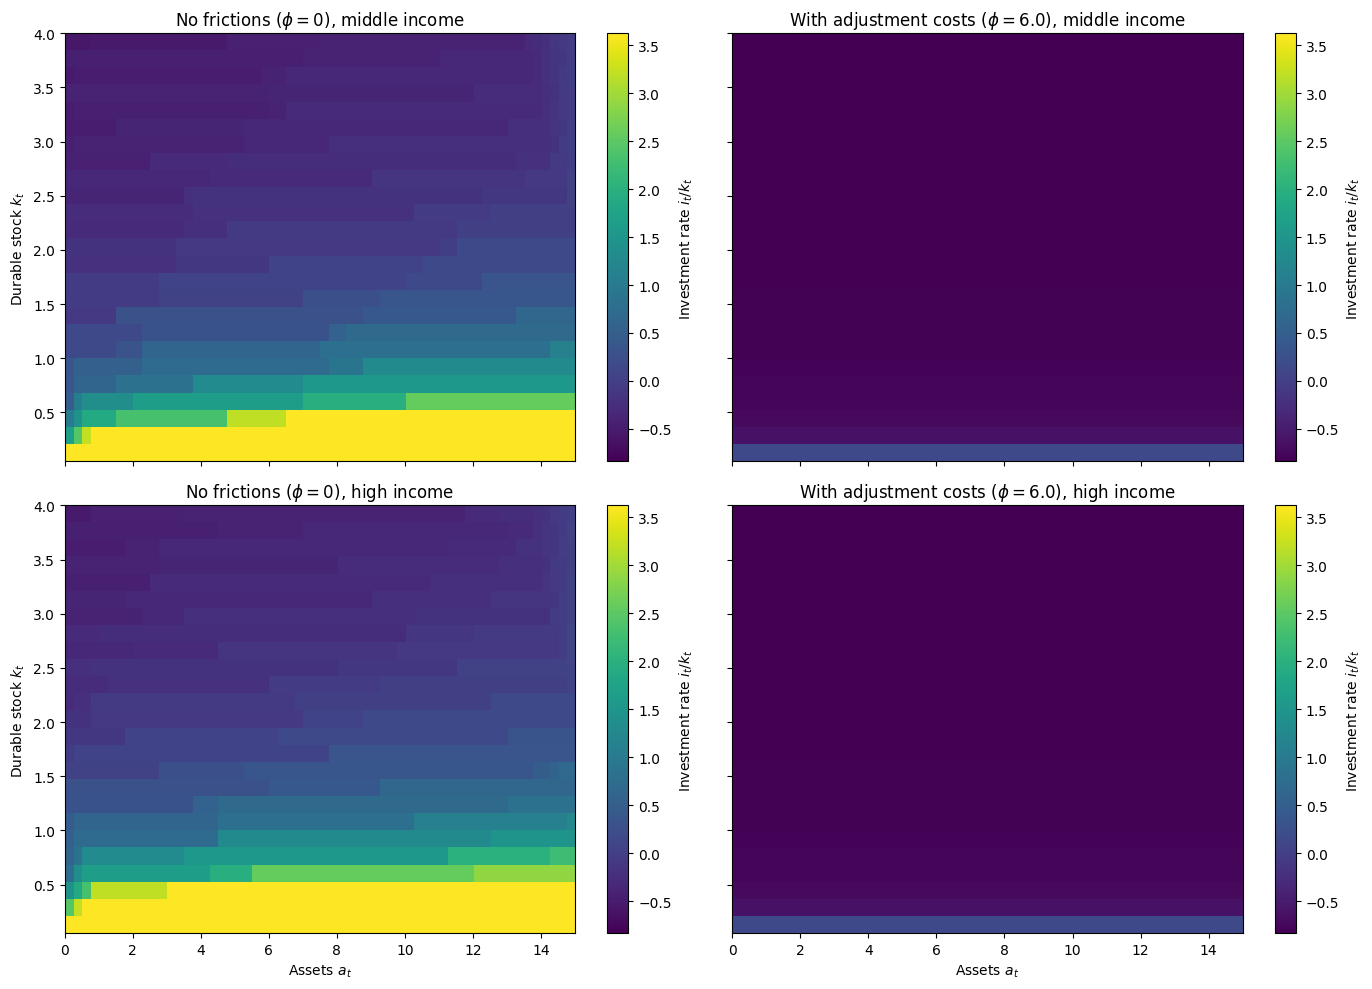

In [20]:
# 4) Heatmaps: investment rate with and without frictions
import matplotlib.pyplot as plt

# Choose an "average" and a "high" income state
iy_mid  = Ny // 2
iy_high = min(Ny - 1, iy_mid + 2)

# For consistent color scales, compute percentiles across both models
vals_mid = np.concatenate([
    inv_rate_nofric[:, :, iy_mid].ravel(),
    inv_rate_fric[:,   :, iy_mid].ravel()
])
vals_high = np.concatenate([
    inv_rate_nofric[:, :, iy_high].ravel(),
    inv_rate_fric[:,   :, iy_high].ravel()
])

vmin_mid,  vmax_mid  = np.percentile(vals_mid,  [5, 95])
vmin_high, vmax_high = np.percentile(vals_high, [5, 95])

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Panel (1,1): no friction, middle income
im00 = axes[0, 0].imshow(
    inv_rate_nofric[:, :, iy_mid].T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin_mid,
    vmax=vmax_mid,
)
axes[0, 0].set_title(r"No frictions ($\phi = 0$), middle income")
axes[0, 0].set_ylabel("Durable stock $k_t$")
cbar00 = fig.colorbar(im00, ax=axes[0, 0])
cbar00.set_label("Investment rate $i_t/k_t$")

# Panel (1,2): with frictions, middle income
im01 = axes[0, 1].imshow(
    inv_rate_fric[:, :, iy_mid].T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin_mid,
    vmax=vmax_mid,
)
axes[0, 1].set_title(r"With adjustment costs ($\phi = {:.1f}$), middle income".format(phi))
cbar01 = fig.colorbar(im01, ax=axes[0, 1])
cbar01.set_label("Investment rate $i_t/k_t$")

# Panel (2,1): no friction, high income
im10 = axes[1, 0].imshow(
    inv_rate_nofric[:, :, iy_high].T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin_high,
    vmax=vmax_high,
)
axes[1, 0].set_title(r"No frictions ($\phi = 0$), high income")
axes[1, 0].set_xlabel("Assets $a_t$")
axes[1, 0].set_ylabel("Durable stock $k_t$")
cbar10 = fig.colorbar(im10, ax=axes[1, 0])
cbar10.set_label("Investment rate $i_t/k_t$")

# Panel (2,2): with frictions, high income
im11 = axes[1, 1].imshow(
    inv_rate_fric[:, :, iy_high].T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin_high,
    vmax=vmax_high,
)
axes[1, 1].set_title(r"With adjustment costs ($\phi = {:.1f}$), high income".format(phi))
axes[1, 1].set_xlabel("Assets $a_t$")
cbar11 = fig.colorbar(im11, ax=axes[1, 1])
cbar11.set_label("Investment rate $i_t/k_t$")

plt.tight_layout()
plt.show()


In [21]:
# INACTION REGION + ADJUSTMENT DISTRIBUTION

In [22]:
# ==== D1. Helper: simulate panel and inaction statistics ====

def simulate_investment_panel(pol_a_idx_in, pol_k_idx_in, phi_val,
                              N_agents=5000, T_total=400, burn_in=200,
                              eps_band=0.01, label=""):
    """
    Simulate many households under given policies and return:
      - visits_counts[Na, Nk]: visits to each (a,k) after burn_in
      - inaction_counts[Na, Nk]: visits with |i/k - deltaK| < eps_band
      - adj_array: vector of net adjustment rates (i/k - deltaK) after burn_in

    pol_a_idx_in, pol_k_idx_in: integer policy index arrays of shape (Na, Nk, Ny).
    phi_val is only used for labeling; policies are assumed to be solved for that phi.
    """

    assert burn_in < T_total

    # Start everyone at low assets, low durables, middle income (arbitrary but convenient)
    ia = np.zeros(N_agents, dtype=int)
    ik = np.zeros(N_agents, dtype=int)
    iy = np.full(N_agents, Ny // 2, dtype=int)

    visits_counts   = np.zeros((Na, Nk), dtype=np.int64)
    inaction_counts = np.zeros((Na, Nk), dtype=np.int64)

    adj_list = []

    for t in range(T_total):
        for n in range(N_agents):
            ia_n = ia[n]
            ik_n = ik[n]
            iy_n = iy[n]

            a_n = a_grid[ia_n]
            k_n = k_grid[ik_n]
            y_n = y_grid[iy_n]

            # Next-period indices from policy
            ia_next = pol_a_idx_in[ia_n, ik_n, iy_n]
            ik_next = pol_k_idx_in[ia_n, ik_n, iy_n]

            a_next = a_grid[ia_next]
            k_next = k_grid[ik_next]

            # Income transition
            iy_next = rng.choice(Ny, p=P_y[iy_n, :])
            y_next = y_grid[iy_next]

            # Current investment and net adjustment rate
            i_now = k_next - (1.0 - deltaK) * k_n
            inv_rate_now = i_now / k_n
            net_adj = inv_rate_now - deltaK  # deviation from pure maintenance

            if t >= burn_in:
                visits_counts[ia_n, ik_n] += 1
                if abs(net_adj) < eps_band:
                    inaction_counts[ia_n, ik_n] += 1
                adj_list.append(net_adj)

            # Update states
            ia[n] = ia_next
            ik[n] = ik_next
            iy[n] = iy_next

    adj_array = np.array(adj_list)

    total_visits = max(visits_counts.sum(), 1)
    overall_inact = inaction_counts.sum() / total_visits
    if label:
        print(f"[{label}] obs after burn-in: {adj_array.size}, "
              f"overall inaction share = {overall_inact:.3f}")
    else:
        print(f"obs after burn-in: {adj_array.size}, "
              f"overall inaction share = {overall_inact:.3f}")

    return visits_counts, inaction_counts, adj_array


In [23]:
# ==== D2. Simulate panels: with frictions and without ====

eps_band = 0.01  # "inaction band" half-width in investment-rate units

# With adjustment costs (baseline phi)
visits_fric, inact_fric, adj_fric = simulate_investment_panel(
    pol_a_idx_in = pol_a_idx,
    pol_k_idx_in = pol_k_idx,
    phi_val      = phi,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    eps_band     = eps_band,
    label        = f"phi={phi:.1f}",
)

# Without adjustment costs (phi = 0) – requires pol_*_nofric from the φ=0 solution
visits_nofric, inact_nofric, adj_nofric = simulate_investment_panel(
    pol_a_idx_in = pol_a_idx_nofric,
    pol_k_idx_in = pol_k_idx_nofric,
    phi_val      = 0.0,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    eps_band     = eps_band,
    label        = "phi=0.0",
)


[phi=6.0] obs after burn-in: 1000000, overall inaction share = 1.000
[phi=0.0] obs after burn-in: 1000000, overall inaction share = 0.482


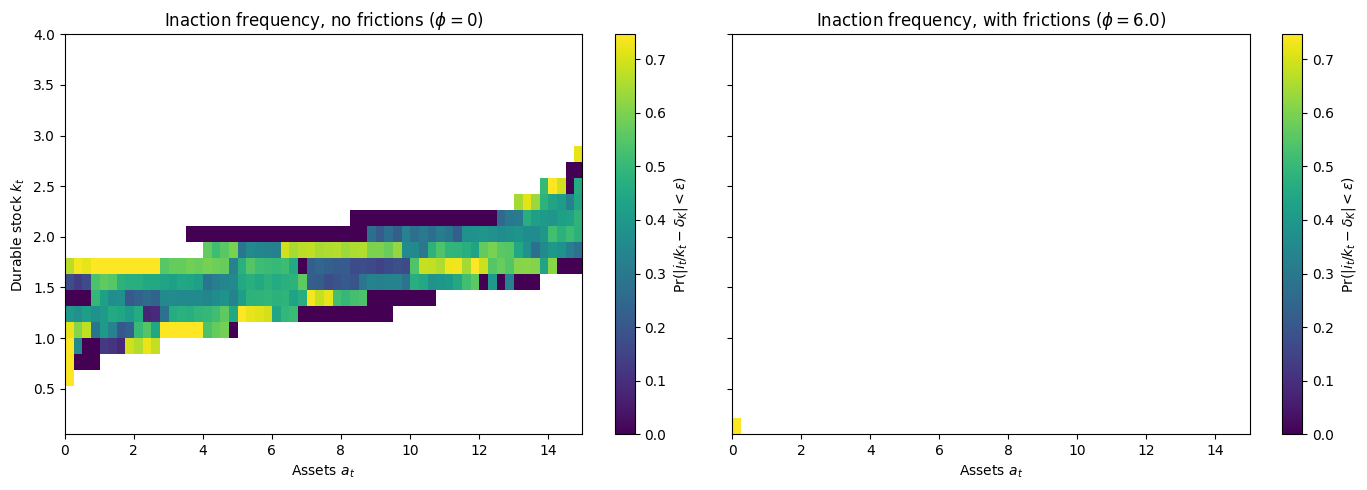

In [24]:
# ==== D3. Inaction region heatmaps over (a_t, k_t) ====

import numpy as np
import matplotlib.pyplot as plt

# Inaction frequency per (a,k), masking states never visited
inaction_share_fric   = np.full((Na, Nk), np.nan)
mask_fric             = visits_fric > 0
inaction_share_fric[mask_fric] = inact_fric[mask_fric] / visits_fric[mask_fric]

inaction_share_nofric = np.full((Na, Nk), np.nan)
mask_nofric           = visits_nofric > 0
inaction_share_nofric[mask_nofric] = inact_nofric[mask_nofric] / visits_nofric[mask_nofric]

# Common color scale (ignore NaNs)
all_vals = np.concatenate([
    inaction_share_nofric[mask_nofric].ravel(),
    inaction_share_fric[mask_fric].ravel()
])
vmin = 0.0
vmax = np.nanpercentile(all_vals, 95)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Panel 1: no frictions
im0 = axes[0].imshow(
    inaction_share_nofric.T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
axes[0].set_title("Inaction frequency, no frictions ($\\phi=0$)")
axes[0].set_xlabel("Assets $a_t$")
axes[0].set_ylabel("Durable stock $k_t$")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label(r"$\Pr(|i_t/k_t - \delta_K| < \varepsilon)$")

# Panel 2: with frictions
im1 = axes[1].imshow(
    inaction_share_fric.T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
axes[1].set_title(f"Inaction frequency, with frictions ($\\phi={phi:.1f}$)")
axes[1].set_xlabel("Assets $a_t$")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label(r"$\Pr(|i_t/k_t - \delta_K| < \varepsilon)$")

plt.tight_layout()
plt.show()


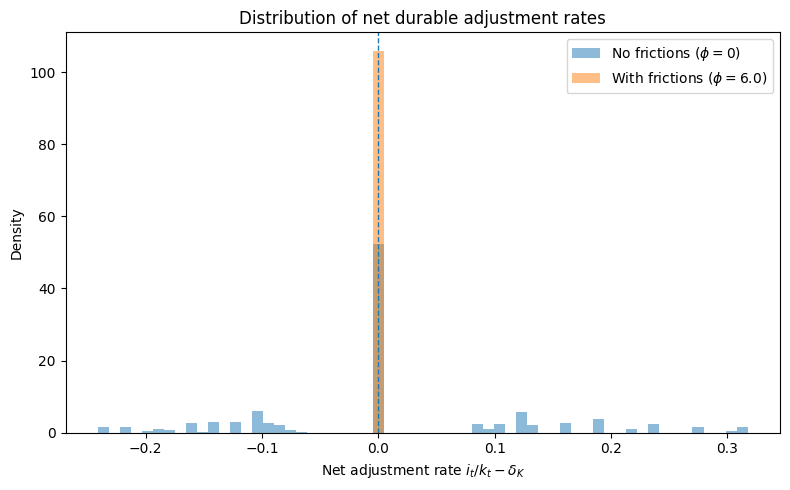

Overall inaction share (no frictions): 0.482
Overall inaction share (with frictions): 1.000
(eps_band = 0.010 around maintenance investment rate)


In [25]:
# ==== D4. Distribution of net adjustment rates: with vs without frictions ====

# Stack both to pick a sensible bin range
all_adj = np.concatenate([adj_nofric, adj_fric])
low, high = np.percentile(all_adj, [1, 99])
bins = np.linspace(low, high, 60)

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(adj_nofric, bins=bins, density=True, alpha=0.5,
        label="No frictions ($\\phi=0$)")
ax.hist(adj_fric,   bins=bins, density=True, alpha=0.5,
        label=f"With frictions ($\\phi={phi:.1f}$)")

ax.axvline(0.0, linestyle="--", linewidth=1)
ax.set_xlabel(r"Net adjustment rate $i_t/k_t - \delta_K$")
ax.set_ylabel("Density")
ax.set_title("Distribution of net durable adjustment rates")
ax.legend()

plt.tight_layout()
plt.show()

# Overall inaction shares (for text/tables)
overall_inact_nofric = inact_nofric.sum() / max(visits_nofric.sum(), 1)
overall_inact_fric   = inact_fric.sum() / max(visits_fric.sum(), 1)

print(f"Overall inaction share (no frictions): {overall_inact_nofric:.3f}")
print(f"Overall inaction share (with frictions): {overall_inact_fric:.3f}")
print(f"(eps_band = {eps_band:.3f} around maintenance investment rate)")


In [26]:
# VOLATILITY, COMPOSITION, and Q-THEORY DIAGNOSTICS

In [27]:
# ==== V1. Simulate a panel with flows for volatility and q-diagnostics ====

def simulate_panel_flows(pol_a_idx_in, pol_k_idx_in, phi_val,
                         N_agents=5000, T_total=400, burn_in=200,
                         label=""):
    """
    Simulate many households under given policies and collect:
      - y_series, c_series, i_series, k_series, a_series (flattened over agents & time)
      - ia_series, ik_series, iy_series (grid indices, same flattening)

    The flow variables are recorded for periods t >= burn_in.
    Policies are assumed to have shape (Na, Nk, Ny).
    """

    assert burn_in < T_total

    # Initial conditions: low assets, low k, middle income (arbitrary but convenient)
    ia = np.zeros(N_agents, dtype=int)
    ik = np.zeros(N_agents, dtype=int)
    iy = np.full(N_agents, Ny // 2, dtype=int)

    y_list  = []
    c_list  = []
    i_list  = []
    k_list  = []
    a_list  = []

    ia_list = []
    ik_list = []
    iy_list = []

    for t in range(T_total):
        for n in range(N_agents):
            ia_n = ia[n]
            ik_n = ik[n]
            iy_n = iy[n]

            a_n = a_grid[ia_n]
            k_n = k_grid[ik_n]
            y_n = y_grid[iy_n]

            # Policy-implied next states
            ia_next = pol_a_idx_in[ia_n, ik_n, iy_n]
            ik_next = pol_k_idx_in[ia_n, ik_n, iy_n]

            a_next = a_grid[ia_next]
            k_next = k_grid[ik_next]

            # Income transition
            iy_next = rng.choice(Ny, p=P_y[iy_n, :])

            # Durable investment and adjustment cost
            i_now = k_next - (1.0 - deltaK) * k_n
            inv_rate_now = i_now / k_n
            # Convex adjustment cost; zero if phi_val = 0
            Phi_now = 0.5 * phi_val * (inv_rate_now - deltaK)**2 * k_n

            # Budget constraint: c = (1+r)a + y - a' - p_D * i - Phi
            coh = (1.0 + r) * a_n + y_n
            c_now = coh - a_next - pD * i_now - Phi_now

            if t >= burn_in:
                y_list.append(y_n)
                c_list.append(c_now)
                i_list.append(i_now)
                k_list.append(k_n)
                a_list.append(a_n)

                ia_list.append(ia_n)
                ik_list.append(ik_n)
                iy_list.append(iy_n)

            # Update states
            ia[n] = ia_next
            ik[n] = ik_next
            iy[n] = iy_next

    y_series  = np.array(y_list)
    c_series  = np.array(c_list)
    i_series  = np.array(i_list)
    k_series  = np.array(k_list)
    a_series  = np.array(a_list)

    ia_series = np.array(ia_list, dtype=int)
    ik_series = np.array(ik_list, dtype=int)
    iy_series = np.array(iy_list, dtype=int)

    if label:
        print(f"[{label}] simulated obs after burn-in: {y_series.size}")
    else:
        print(f"simulated obs after burn-in: {y_series.size}")

    return {
        "y":   y_series,
        "c":   c_series,
        "i":   i_series,
        "k":   k_series,
        "a":   a_series,
        "ia":  ia_series,
        "ik":  ik_series,
        "iy":  iy_series,
    }


In [28]:
# ==== V2. Volatility and composition: simulate and compute moments ====

import numpy as np
import pandas as pd

# Simulate under baseline frictions (phi)
panel_fric = simulate_panel_flows(
    pol_a_idx_in = pol_a_idx,
    pol_k_idx_in = pol_k_idx,
    phi_val      = phi,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    label        = f"phi={phi:.1f}",
)

# Simulate under frictionless policies (phi = 0)
panel_nofric = simulate_panel_flows(
    pol_a_idx_in = pol_a_idx_nofric,
    pol_k_idx_in = pol_k_idx_nofric,
    phi_val      = 0.0,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    label        = "phi=0.0",
)

def compute_moments(panel):
    y = panel["y"]
    c = panel["c"]
    i = panel["i"]

    # Logs for y and c (always positive)
    log_y = np.log(y)
    log_c = np.log(c)

    # Volatilities (std devs)
    moments = {}
    moments["std_log_y"] = float(np.std(log_y))
    moments["std_log_c"] = float(np.std(log_c))
    moments["std_i"]     = float(np.std(i))          # level volatility of investment
    moments["std_k"]     = float(np.std(panel["k"])) # level volatility of stock

    # Contemporaneous correlations with income
    moments["corr_log_c_log_y"] = float(np.corrcoef(log_c, log_y)[0, 1])
    moments["corr_i_y"]         = float(np.corrcoef(i, y)[0, 1])

    # Simple "beta" from changes: Δ log c on Δ log y; Δ i on Δ y
    # (drop first diff)
    dlog_y = np.diff(log_y)
    dlog_c = np.diff(log_c)
    dy     = np.diff(y)
    di     = np.diff(i)

    # Guard against near-constant shocks
    if np.var(dlog_y) > 0:
        beta_c = np.cov(dlog_c, dlog_y, bias=True)[0, 1] / np.var(dlog_y)
    else:
        beta_c = np.nan

    if np.var(dy) > 0:
        beta_i = np.cov(di, dy, bias=True)[0, 1] / np.var(dy)
    else:
        beta_i = np.nan

    moments["beta_dlogc_dlogy"] = float(beta_c)
    moments["beta_di_dy"]       = float(beta_i)

    return moments

mom_fric   = compute_moments(panel_fric)
mom_nofric = compute_moments(panel_nofric)

# Put into a neat table
moments_df = pd.DataFrame(
    {
        "No frictions (phi=0)":      mom_nofric,
        f"With frictions (phi={phi:.1f})": mom_fric,
    }
)

display(moments_df)


[phi=6.0] simulated obs after burn-in: 1000000
[phi=0.0] simulated obs after burn-in: 1000000


,No frictions (phi=0),With frictions (phi=6.0)
std_log_y,0.315513,3.151955e-01
std_log_c,0.283617,3.176815e-01
std_i,0.153154,1.908196e-17
std_k,0.389044,1.040834e-16
corr_log_c_log_y,0.849948,9.999989e-01
corr_i_y,0.413474,8.414377e-18
beta_dlogc_dlogy,0.763290,1.007886e+00
beta_di_dy,0.189429,0.000000e+00


In [29]:
# ==== V3. q-theory diagnostics: cost-based q and value-based q ====

# --- 1) Cost-based q in the frictional model ---

# Only for frictional panel
y_f = panel_fric["y"]
c_f = panel_fric["c"]
i_f = panel_fric["i"]
k_f = panel_fric["k"]

# Investment rate and net adjustment (relative to maintenance)
inv_rate_f = i_f / k_f
net_adj_f  = inv_rate_f - deltaK

# Cost-based Tobin's q: marginal acquisition cost per unit of installed durables
q_cost_f = pD + phi * net_adj_f

print("Cost-based q (frictional model):")
print(f"  mean(q_cost) = {q_cost_f.mean():.4f}, std(q_cost) = {q_cost_f.std():.4f}")

# --- 2) Value-based q ≈ ∂V/∂k via finite differences on the k-grid ---

def compute_q_value_series(panel, V_fric):
    """
    Given a panel dict (with 'ia', 'ik', 'iy') and frictional value function V_fric (Na, Nk, Ny),
    compute a series q_val ≈ ∂V/∂k at each observation via finite differences along k-grid.
    """
    ia_s = panel["ia"]
    ik_s = panel["ik"]
    iy_s = panel["iy"]

    N_obs = ia_s.size
    q_val = np.empty(N_obs)

    for idx in range(N_obs):
        ia_i = ia_s[idx]
        ik_i = ik_s[idx]
        iy_i = iy_s[idx]

        if ik_i == 0:
            # forward difference
            V0 = V_fric[ia_i, ik_i,     iy_i]
            V1 = V_fric[ia_i, ik_i + 1, iy_i]
            dk = k_grid[ik_i + 1] - k_grid[ik_i]
            q_val[idx] = (V1 - V0) / dk
        elif ik_i == Nk - 1:
            # backward difference
            V0 = V_fric[ia_i, ik_i - 1, iy_i]
            V1 = V_fric[ia_i, ik_i,     iy_i]
            dk = k_grid[ik_i] - k_grid[ik_i - 1]
            q_val[idx] = (V1 - V0) / dk
        else:
            # central difference
            Vm = V_fric[ia_i, ik_i - 1, iy_i]
            Vp = V_fric[ia_i, ik_i + 1, iy_i]
            dk = k_grid[ik_i + 1] - k_grid[ik_i - 1]
            q_val[idx] = (Vp - Vm) / dk

    return q_val

# Assuming V is the converged value function for the frictional model
q_val_f = compute_q_value_series(panel_fric, V)

print("Value-based q (frictional model):")
print(f"  mean(q_val) = {q_val_f.mean():.4f}, std(q_val) = {q_val_f.std():.4f}")
print(f"  corr(inv_rate, q_val) = {np.corrcoef(inv_rate_f, q_val_f)[0,1]:.4f}")

# --- 3) Binned scatter: investment rate vs value-based q ---

def binned_scatter(x, y, n_bins=20):
    """
    Simple binned scatter: divide x into quantile bins and compute mean x, mean y in each bin.
    Returns bin_means_x, bin_means_y.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Drop NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # Quantile bin edges
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(x, qs)

    bin_means_x = []
    bin_means_y = []

    for b in range(n_bins):
        lo, hi = edges[b], edges[b+1]
        if b < n_bins - 1:
            in_bin = (x >= lo) & (x < hi)
        else:
            in_bin = (x >= lo) & (x <= hi)

        if np.any(in_bin):
            bin_means_x.append(x[in_bin].mean())
            bin_means_y.append(y[in_bin].mean())

    return np.array(bin_means_x), np.array(bin_means_y)

# Use middle 98% of q_val to avoid extreme tails
qv = q_val_f
mask_mid = (qv > np.quantile(qv, 0.01)) & (qv < np.quantile(qv, 0.99))

x_bins, y_bins = binned_scatter(qv[mask_mid], inv_rate_f[mask_mid], n_bins=20)

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(x_bins, y_bins, marker="o", linestyle="-")
plt.xlabel("Value-based q (approx. ∂V/∂k)")
plt.ylabel("Investment rate $i_t/k_t$")
plt.title("Binned relationship between investment and value-based q (frictional model)")
plt.tight_layout()
plt.show()


Cost-based q (frictional model):
  mean(q_cost) = 1.0000, std(q_cost) = 0.0000
Value-based q (frictional model):
  mean(q_val) = 0.0000, std(q_val) = 0.0000
  corr(inv_rate, q_val) = nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# Re-solve frictional model using the same helper
V_fric_check, pol_a_idx_fric_check, pol_k_idx_fric_check = solve_model_for_phi(
    phi_val=phi,
    max_iter=500,
    tol=1e-5,
    verbose=True,
)

# Re-solve frictionless model
V_nofric_check, pol_a_idx_nofric_check, pol_k_idx_nofric_check = solve_model_for_phi(
    phi_val=0.0,
    max_iter=500,
    tol=1e-5,
    verbose=True,
)

# Now compare
iy_mid = Ny // 2
DeltaV_mid = V_nofric_check[:, :, iy_mid] - V_fric_check[:, :, iy_mid]
print(DeltaV_mid.min(), DeltaV_mid.max())


[phi=6.000] iter 1: sup diff = 8.925e+00
[phi=6.000] iter 2: sup diff = 8.476e+00
[phi=6.000] iter 3: sup diff = 8.068e+00
[phi=6.000] iter 4: sup diff = 7.691e+00
[phi=6.000] iter 5: sup diff = 7.338e+00
[phi=6.000] iter 6: sup diff = 7.007e+00
[phi=6.000] iter 7: sup diff = 6.676e+00
[phi=6.000] iter 8: sup diff = 6.161e+00
[phi=6.000] iter 9: sup diff = 4.193e+00
[phi=6.000] iter 10: sup diff = 2.117e+00
[phi=6.000] iter 11: sup diff = 1.949e+00
[phi=6.000] iter 12: sup diff = 1.771e+00
[phi=6.000] iter 13: sup diff = 1.623e+00
[phi=6.000] iter 14: sup diff = 1.473e+00
[phi=6.000] iter 15: sup diff = 1.354e+00
[phi=6.000] iter 16: sup diff = 1.253e+00
[phi=6.000] iter 17: sup diff = 1.166e+00
[phi=6.000] iter 18: sup diff = 1.087e+00
[phi=6.000] iter 19: sup diff = 1.018e+00
[phi=6.000] iter 20: sup diff = 9.573e-01
[phi=6.000] iter 21: sup diff = 9.025e-01
[phi=6.000] iter 22: sup diff = 8.526e-01
[phi=6.000] iter 23: sup diff = 8.066e-01
[phi=6.000] iter 24: sup diff = 7.638e-01
[

[welfare] min DeltaV_mid = -47.5671, max DeltaV_mid = -24.4601


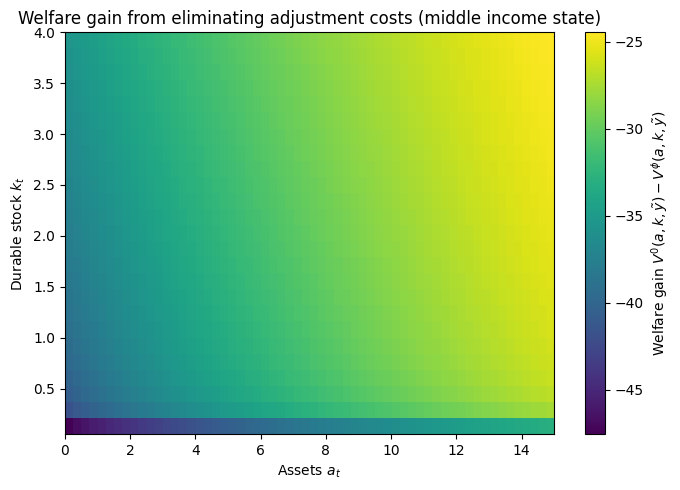

In [30]:
# ==== W1. Welfare loss on the (a, k) grid: V^0 - V^phi ====

# We assume:
#   V        : value function with frictions, shape (Na, Nk, Ny)
#   V_nofric : value function without frictions (phi=0), same shape

# Choose an income state to visualise, e.g. middle income
iy_mid = Ny // 2

# Welfare difference at that income state
DeltaV_mid = V_nofric[:, :, iy_mid] - V[:, :, iy_mid]

print(f"[welfare] min DeltaV_mid = {DeltaV_mid.min():.4f}, "
      f"max DeltaV_mid = {DeltaV_mid.max():.4f}")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5))
im = plt.imshow(
    DeltaV_mid.T,
    origin="lower",
    extent=[a_grid[0], a_grid[-1], k_grid[0], k_grid[-1]],
    aspect="auto",
)
plt.colorbar(im, label=r"Welfare gain $V^{0}(a,k,\tilde y) - V^{\phi}(a,k,\tilde y)$")
plt.xlabel("Assets $a_t$")
plt.ylabel("Durable stock $k_t$")
plt.title("Welfare gain from eliminating adjustment costs (middle income state)")
plt.tight_layout()
plt.show()


In [31]:
# ==== W2. Average welfare in the stationary distribution ====

# If you already ran these earlier, you can skip re-running.
# Otherwise, simulate panels for frictional and frictionless models.

panel_fric = simulate_panel_flows(
    pol_a_idx_in = pol_a_idx,
    pol_k_idx_in = pol_k_idx,
    phi_val      = phi,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    label        = f"phi={phi:.1f}",
)

panel_nofric = simulate_panel_flows(
    pol_a_idx_in = pol_a_idx_nofric,
    pol_k_idx_in = pol_k_idx_nofric,
    phi_val      = 0.0,
    N_agents     = 5000,
    T_total      = 400,
    burn_in      = 200,
    label        = "phi=0.0",
)

def average_welfare(panel, V_func):
    """
    Given a simulated panel dict with 'ia','ik','iy' and a value function V_func(a,k,y),
    return the average V over all post-burn-in observations.
    """
    ia = panel["ia"]
    ik = panel["ik"]
    iy = panel["iy"]
    # Grab V at each realised state
    V_vals = V_func[ia, ik, iy]
    return float(V_vals.mean())

Vbar_fric   = average_welfare(panel_fric,   V)
Vbar_nofric = average_welfare(panel_nofric, V_nofric)

print(f"Average welfare with frictions (phi={phi:.1f}): {Vbar_fric:.6f}")
print(f"Average welfare without frictions (phi=0):      {Vbar_nofric:.6f}")
print(f"Difference (no frictions minus frictions):      {Vbar_nofric - Vbar_fric:.6f}")


[phi=6.0] simulated obs after burn-in: 1000000
[phi=0.0] simulated obs after burn-in: 1000000
Average welfare with frictions (phi=6.0): 0.000000
Average welfare without frictions (phi=0):      -36.357523
Difference (no frictions minus frictions):      -36.357523


In [32]:
# ==== W3. Consumption-equivalent variation based on average welfare ====

gamma = 2.0  # <-- set this to your actual CRRA coefficient for consumption

def cev_from_values(V_fric, V_nofric, gamma):
    """
    Compute the consumption-equivalent variation lambda such that
    V_fric = (1 - lambda)^{1-gamma} * V_nofric.
    Positive lambda means: frictions are as bad as a permanent lambda drop in c.
    """
    if gamma == 1.0:
        raise ValueError("This simple CEV formula does not handle gamma = 1 (log utility).")

    ratio = V_fric / V_nofric
    # Guard against tiny numerical negatives or >1 issues
    if ratio <= 0:
        return np.nan
    lam = 1.0 - ratio**(1.0 / (1.0 - gamma))
    return lam

lambda_cev_avg = cev_from_values(Vbar_fric, Vbar_nofric, gamma)

print(f"CEV (stationary-average): "
      f"lambda = {lambda_cev_avg:.4%} loss in nondurable consumption")


CEV (stationary-average): lambda = nan% loss in nondurable consumption
